# Integrating PySulfSat with PetThermoTools
- This notebook can perform MELTS calculations, and then go onto calculate the SCSS and SCAS within a single notebook!
- It relies on the python MELTS architecture developed by Paula Antoshechkin at Caltech, and fractional crystallization functions written by Matthew Gleeson at UC Berkeley
- In addition to installing PySulfSat you will need to first download the MELTS python infrastructure from this website (https://magmasource.caltech.edu/gitlist/MELTS_Matlab.git/), and then the PetThermoTools code by uncommenting below
- More information can be found here: https://github.com/gleesonm1/PetThermoTools
You can download the excel spreadsheet with the compositions here:
- https://github.com/PennyWieser/PySulfSat/blob/main/docs/Examples/Integrating_with_PyMELTS/Glass_input_example.xlsx

## If you havent done so already, you need to pip install PySulfSat
- Do this by removing the #. You only need to do this once per computer. After your initial installation, you will want to upgrade instead using the second command


In [1]:
#!pip install PySulfSat
#!pip install PySulfSat --upgrade

## Now you need to append the path to your local MELTS installation

In [2]:
import sys
sys.path.append(r'C:\Users\penny\Box\Berkeley_new\MELTS_python_Paula\melts_matlab_git_master\package')

## And now you need to download the PetThermoTools code by uncommenting this line
- you will need to be on at least 0.1.3 to get the logfo2 output needed here

In [3]:
#!pip install --upgrade PetThermoTools

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PySulfSat as ss
import PetThermoTools as M

In [5]:
### Use these version numbers when communicating problems to Penny (ss) and Matt (M.)

In [6]:
ss.__version__

'1.0.4'

In [7]:
M.__version__

'0.2.3'

## Import data
- Here, we load in some glass EPMA data, and then start a MELTS model from the first row in the loaded spreadsheet

In [8]:
df_out2=ss.import_data('Glass_input_example.xlsx', sheet_name='Glass_input', 
                       suffix="_Liq")
df_out2.head()
# Selecting a single composition to start the model from
sample=df_out2.iloc[0]

We have replaced all missing liquid oxides and strings with zeros. 


## Using PetThermoTools
- Here we initiate a melts fractional crystallizatoin model, see the documentation for that package for more information

In [9]:
P=3000
MELTS_FC=M.multi_path(Model = "MELTSv1.2.0", 
                        Fe3Fet_Liq=0.1,
                          H2O_Liq=6,
                        bulk = sample.to_dict(), 
                        Frac_solid = True, 
                        Frac_fluid = True, 
                        find_liquidus = True,
                        T_end_C = 750, 
                        dt_C = 5, 
                        P_bar = P, 
                        )

Running MELTSv1.2.0 calculation... Complete (time taken = 12.27 seconds)

### Inspecting the outputs from this function

In [10]:
MELTS=MELTS_FC['All']
MELTS.head()

,T_C,P_bar,h,s,v,dvdp,logfO2,SiO2_Liq,TiO2_Liq,Al2O3_Liq,...,Na2O_Rhm,K2O_Rhm,P2O5_Rhm,H2O_Rhm,CO2_Rhm,Fe3Fet_Rhm,h_Rhm,mass_Rhm,v_Rhm,rho_Rhm
0,1115.800000,3000.0,-1.180423e+06,300.413262,41.231226,-0.000300,-10.085365,47.601910,1.925732,12.396428,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,1110.789041,3000.0,-1.181315e+06,299.769691,41.201340,-0.000297,-10.254367,47.747755,1.862039,12.415663,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,1105.778082,3000.0,-1.180174e+06,298.469985,41.103394,-0.000297,-10.428085,47.893104,1.798419,12.434711,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,1100.767123,3000.0,-1.179027e+06,297.177308,41.005868,-0.000297,-10.602652,48.032356,1.737319,12.452845,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,1095.756164,3000.0,-1.177967e+06,295.920560,40.911796,-0.000297,-10.778097,48.165861,1.678584,12.470120,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Mass Frac XH2O')

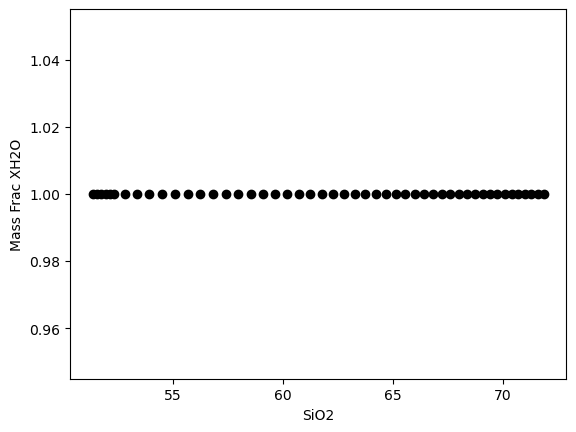

In [11]:
plt.plot(MELTS['SiO2_Liq'], MELTS['H2O_fluid1']/ (MELTS['H2O_fluid1']+MELTS['CO2_fluid1']), 'ok')
plt.xlabel('SiO2')
plt.ylabel('Mass Frac XH2O')

Text(0.5, 0, 'SiO2')

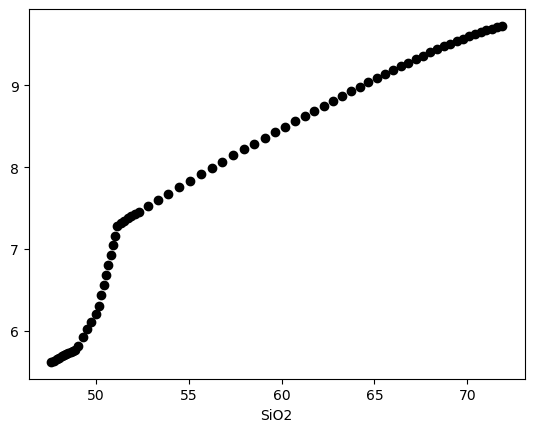

In [12]:
plt.plot(MELTS['SiO2_Liq'], MELTS['H2O_Liq'], 'ok')
plt.xlabel('SiO2')

Text(0.5, 0, 'SiO2')

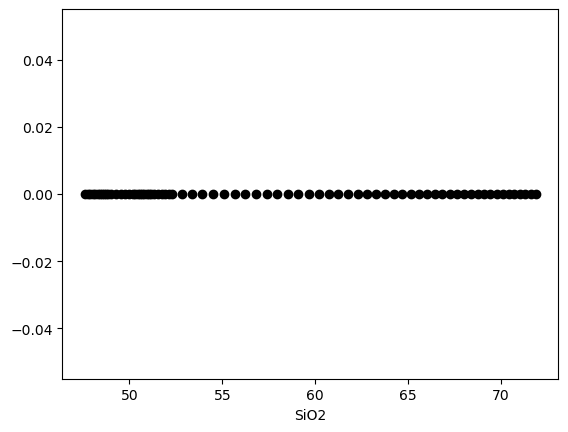

In [13]:
plt.plot(MELTS['SiO2_Liq'], MELTS['CO2_Liq'], 'ok')
plt.xlabel('SiO2')

## Lets see what phases it crystallized..

In [14]:
# Lets see what phases we have!
MELTS.columns[MELTS.columns.str.contains('SiO2')]

Index(['SiO2_Liq', 'SiO2_Sp', 'SiO2_Ol', 'SiO2_Cpx', 'SiO2_Cpx2',
       'SiO2_fluid1', 'SiO2_Plag', 'SiO2_Rhm'],
      dtype='object')

## Calculate SCSS using Li and Zhang 2022

In [15]:
LiZhang22=ss.calculate_LiZhang2022_SCSS(df=MELTS, T_K=MELTS['T_C']+273.15, 
P_kbar=P/1000, 
H2O_Liq=MELTS['H2O_Liq'], Fe_FeNiCu_Sulf=0.6, Fe3Fet_Liq=MELTS['Fe3Fet_Liq'])
LiZhang22.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function


,SCSS_Tot,T_C,P_bar,h,s,v,dvdp,logfO2,SiO2_Liq,TiO2_Liq,...,Al_cat,Fe_cat,Mn_cat,Mg_cat,Ca_cat,Na_cat,K_cat,P_cat,H_cat,Fe3_cat
0,1796.006777,1115.800000,3000.0,-1.180423e+06,300.413262,41.231226,-0.000300,-10.085365,47.601910,1.925732,...,0.146193,0.094161,0.002000,0.092647,0.114037,0.045247,0.002953,0.001500,0.0,0.010448
1,1753.456098,1110.789041,3000.0,-1.181315e+06,299.769691,41.201340,-0.000297,-10.254367,47.747755,1.862039,...,0.146366,0.093409,0.002006,0.092478,0.114344,0.045369,0.002961,0.001504,0.0,0.009949
2,1711.594984,1105.778082,3000.0,-1.180174e+06,298.469985,41.103394,-0.000297,-10.428085,47.893104,1.798419,...,0.146537,0.092658,0.002011,0.092311,0.114650,0.045491,0.002969,0.001508,0.0,0.009455
3,1671.082216,1100.767123,3000.0,-1.179027e+06,297.177308,41.005868,-0.000297,-10.602652,48.032356,1.737319,...,0.146700,0.091936,0.002016,0.092153,0.114944,0.045607,0.002977,0.001512,0.0,0.008986
4,1631.844700,1095.756164,3000.0,-1.177967e+06,295.920560,40.911796,-0.000297,-10.778097,48.165861,1.678584,...,0.146854,0.091242,0.002021,0.092003,0.115225,0.045719,0.002984,0.001515,0.0,0.008540


## Smythe sulfide saturation model

In [16]:
Smythe_CalcSulf=ss.calculate_S2017_SCSS(df=MELTS, 
T_K=MELTS['T_C']+273.15, 
P_kbar=P/1000, Fe_FeNiCu_Sulf=0.65,
Fe3Fet_Liq=MELTS['Fe3Fet_Liq'])

Smythe_CalcSulf.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
no non ideal SCSS as no Cu/CuFeNiCu


,SCSS2_ppm_ideal_Smythe2017,SCSS2_ppm_ideal_Smythe2017_1sigma,T_Input_K,P_Input_kbar,Fe_FeNiCu_Sulf,Fe3Fet_Liq_input,Si_wt_atom,Ti_wt_atom,Al_wt_atom,Mg_wt_atom,...,K2O_Rhm,P2O5_Rhm,H2O_Rhm,CO2_Rhm,Fe3Fet_Rhm,h_Rhm,mass_Rhm,v_Rhm,rho_Rhm,Fe_FeNiCu_Sulf_calc
0,712.724246,194.694722,1388.950000,3.0,0.65,0.099881,0.346392,0.010538,0.106315,0.067376,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.65
1,698.211082,190.730164,1383.939041,3.0,0.65,0.096256,0.347070,0.010178,0.106363,0.067203,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.65
2,683.912837,186.824316,1378.928082,3.0,0.65,0.092592,0.347746,0.009820,0.106409,0.067033,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.65
3,670.031292,183.032297,1373.917123,3.0,0.65,0.089035,0.348391,0.009476,0.106453,0.066871,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.65
4,656.541717,179.347353,1368.906164,3.0,0.65,0.085583,0.349008,0.009147,0.106493,0.066718,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.65


Text(0, 0.5, 'SCSS (Smythe, ppm)')

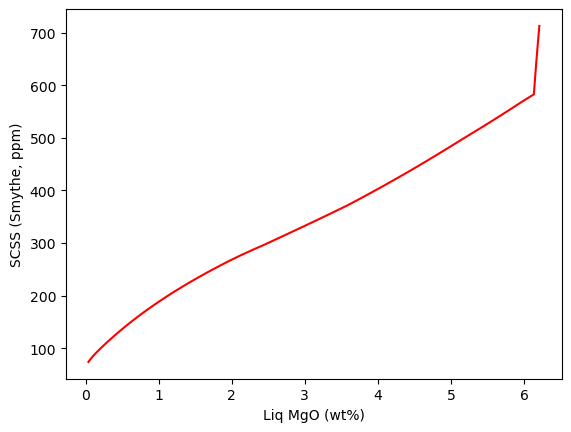

In [17]:
plt.plot(MELTS['MgO_Liq'], Smythe_CalcSulf['SCSS2_ppm_ideal_Smythe2017'],
         '-r')
plt.xlabel('Liq MgO (wt%)')
plt.ylabel('SCSS (Smythe, ppm)')

Text(0, 0.5, 'Liq FeO (wt%)')

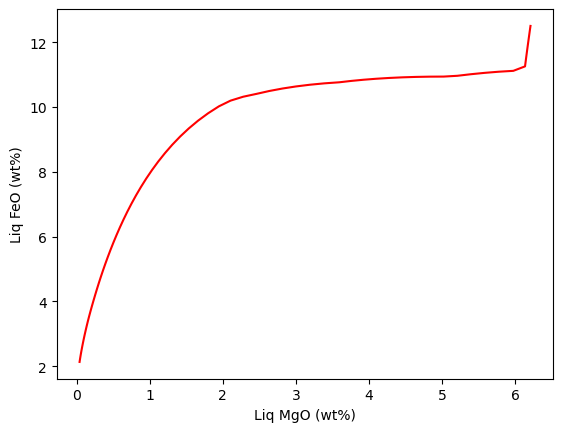

In [18]:
plt.plot( MELTS['MgO_Liq'],MELTS['FeOt_Liq'],
         '-r')
plt.xlabel('Liq MgO (wt%)')
plt.ylabel('Liq FeO (wt%)')

Text(0, 0.5, 'Liq FeO (wt%)')

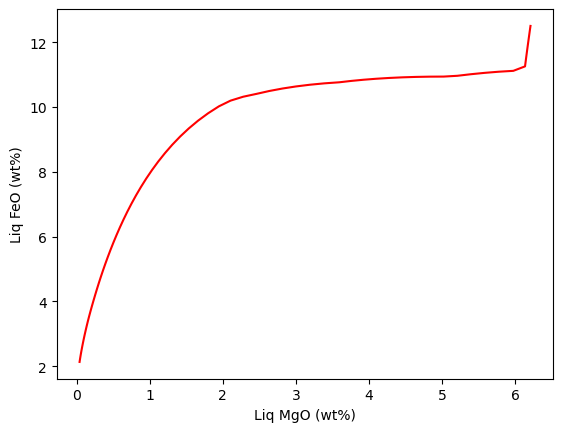

In [19]:
plt.plot( MELTS['MgO_Liq'],MELTS['FeOt_Liq'],
         '-r')
plt.xlabel('Liq MgO (wt%)')
plt.ylabel('Liq FeO (wt%)')

## Using Oneill

In [20]:
ONeill_MeasSulf=ss.calculate_O2021_SCSS(df=MELTS, T_K=MELTS['T_C']+273.15, 
P_kbar=P/1000,
Fe_FeNiCu_Sulf=0.66,
Fe3Fet_Liq=MELTS['Fe3Fet_Liq'])
ONeill_MeasSulf.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.


,SCSS2_ppm,LnS,Ln_a_FeO,Ln_a_FeS,DeltaG,LnCS2_calc,T_C,P_bar,h,s,...,K2O_Rhm,P2O5_Rhm,H2O_Rhm,CO2_Rhm,Fe3Fet_Rhm,h_Rhm,mass_Rhm,v_Rhm,rho_Rhm,Fe_FeNiCu_Sulf_calc
0,1249.373420,7.130397,-2.075625,-0.514565,8.301025,-2.731687,1115.800000,3000.0,-1.180423e+06,300.413262,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.66
1,1214.423494,7.102025,-2.080591,-0.513735,8.340613,-2.805445,1110.789041,3000.0,-1.181315e+06,299.769691,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.66
2,1180.194977,7.073435,-2.085576,-0.512906,8.380502,-2.879738,1105.778082,3000.0,-1.180174e+06,298.469985,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.66
3,1147.581081,7.045412,-2.090345,-0.512110,8.420695,-2.953519,1100.767123,3000.0,-1.179027e+06,297.177308,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.66
4,1116.473074,7.017930,-2.094907,-0.511344,8.461196,-3.026829,1095.756164,3000.0,-1.177967e+06,295.920560,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.66
